# Automated Waste Segregation System Using Computer Vision

## Team Information


Team Number: Group 3

Team Members:

            ● Jasmeet Kaur
            ● Himanshu Kumar
            ● Bharath TS

Team Leader/Representative: Bharath TS

Team GitHub Link: https://github.com/bharath-ts/msaai-ai521-cv-finalproject

## Project Overview

This project builds a deep learning image classifier for garbage/recycling categories using transfer learning. It classifies images into 6 classes: cardboard, glass, metal, paper, plastic, and trash. The workflow covers data exploration, preprocessing, model training, and evaluation.

## 1. Project Setup & Data Loading

### Dataset Structure
The dataset is organized into class-specific folders:
- **Classes Identified**: cardboard, glass, metal, paper, plastic, trash
- **Total Images**: 2,527 images
- **Format**: PNG files

### Data Loading Process
The code loads all images from class-specific directories and creates a structured DataFrame containing file paths and corresponding labels. This enables systematic access to images for training and evaluation.

**Key Finding**: The dataset contains 2,527 images across 6 classes, providing a reasonable foundation for transfer learning approaches.


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Unzip the dataset
!unzip -q "/content/project.zip" -d "/content/project"

In [ ]:
# 1. LOAD DATASET
from pathlib import Path
DATA_DIR = Path("/content/project/Garbage classification/Garbage classification")
classes = os.listdir(DATA_DIR)
print("Classes found:", classes)

image_paths = []
labels = []

for c in classes:
    paths = glob(os.path.join(DATA_DIR, c, "*.jpg"))
    for p in paths:
        image_paths.append(p)
        labels.append(c)

df = pd.DataFrame({"file_path": image_paths, "label": labels})


Classes found: ['metal', 'glass', 'trash', 'plastic', 'paper', 'cardboard']


## 2. Exploratory Data Analysis (EDA)

### 2.1 Class Distribution Analysis
A count plot visualizes the distribution of images across classes, revealing significant class imbalance that needs to be addressed during model training.

**Insight**: The dataset shows imbalanced classes, with "trash" being the minority class. This imbalance requires special handling to prevent model bias toward majority classes.


/tmp/ipython-input-101146891.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["label"], palette="viridis")


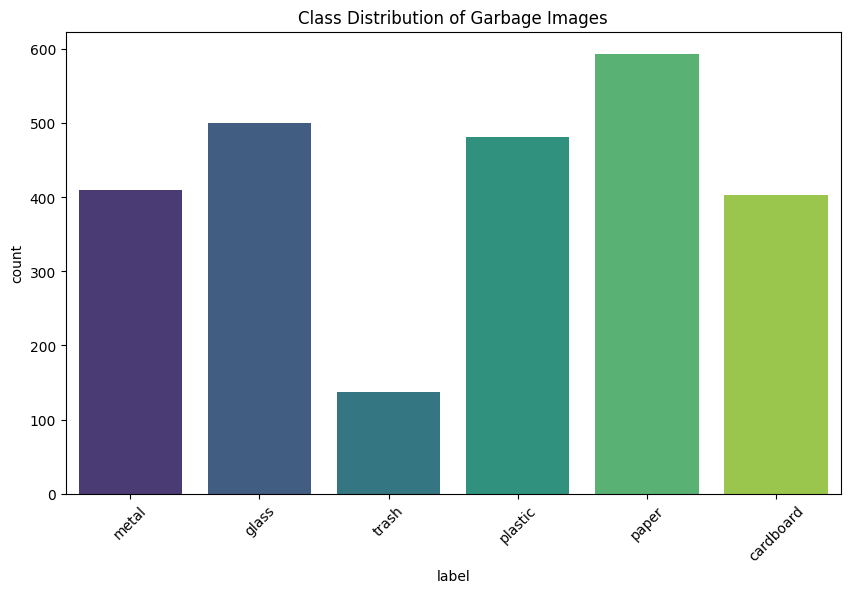

In [ ]:
# 2. CLASS DISTRIBUTION
plt.figure(figsize=(10, 6))
sns.countplot(x=df["label"], palette="viridis")
plt.title("Class Distribution of Garbage Images")
plt.xticks(rotation=45)
plt.show()

### 2.2 Sample Image Visualization
Sample images from each class are displayed to understand visual characteristics and variability within categories.

**Purpose**: Helps identify visual patterns and potential challenges in classification, such as similar appearances between certain classes.

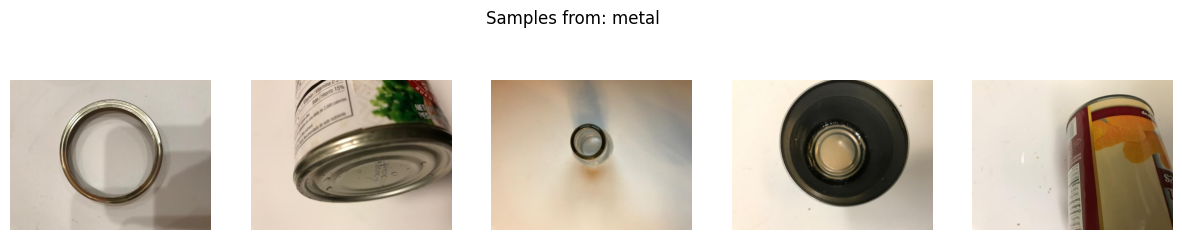

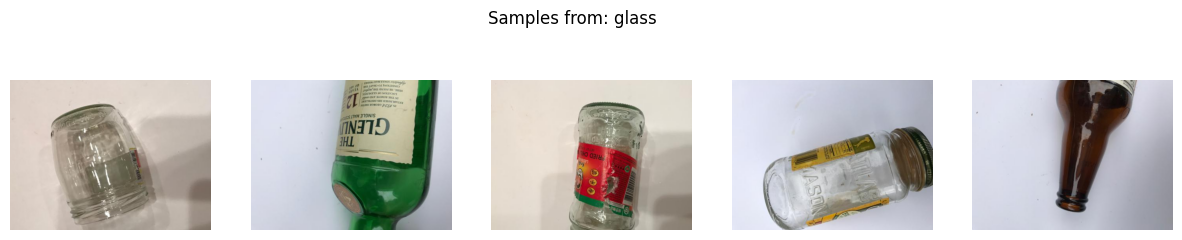

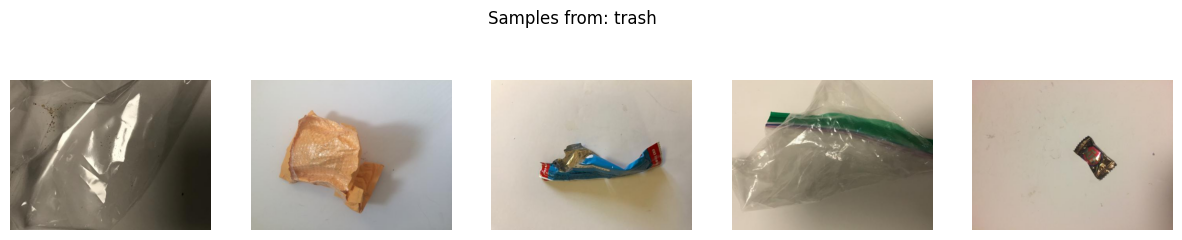

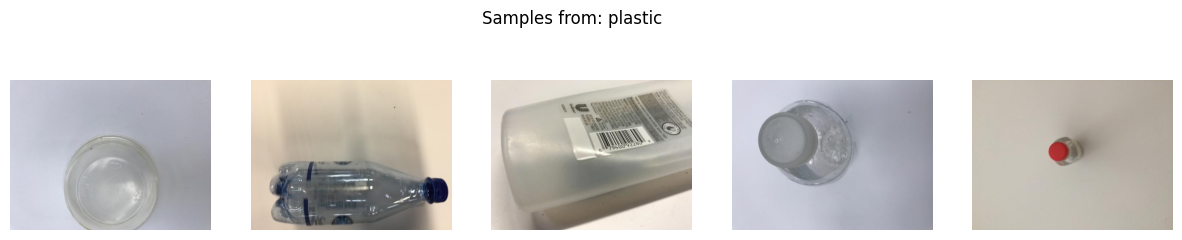

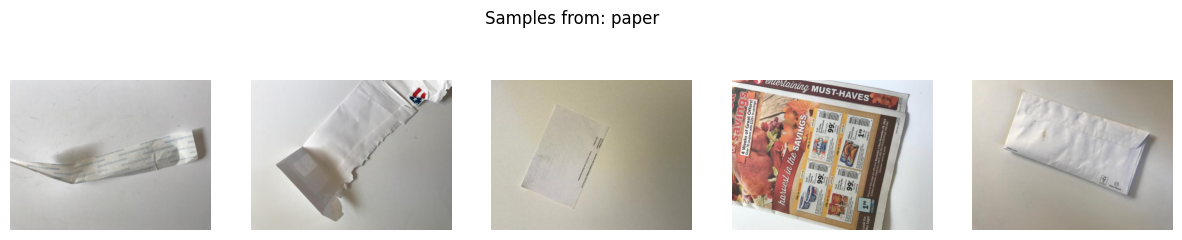

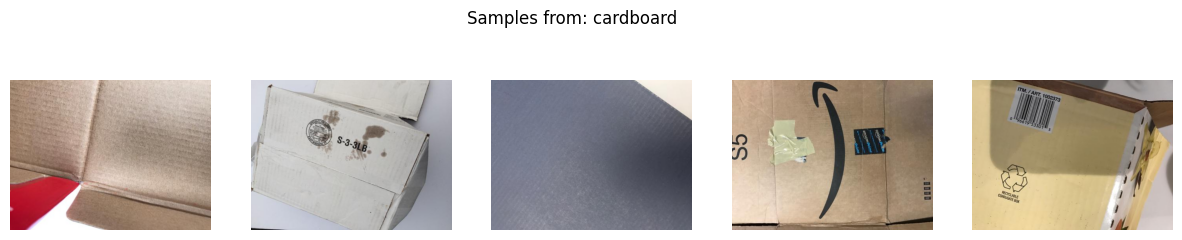

In [ ]:
# 3. SHOW SAMPLE IMAGES
def show_samples(label, n=5):
    files = df[df["label"] == label].sample(n)["file_path"]
    plt.figure(figsize=(15, 3))
    for i, f in enumerate(files):
        img = Image.open(f)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(f"Samples from: {label}")
    plt.show()

for c in classes:
    show_samples(c)

### 2.3 Image Size Analysis
Width and height distributions are analyzed using histograms with kernel density estimation (KDE).

**Finding**: Images vary significantly in dimensions, necessitating standardization to a fixed size (224×224) for model input.


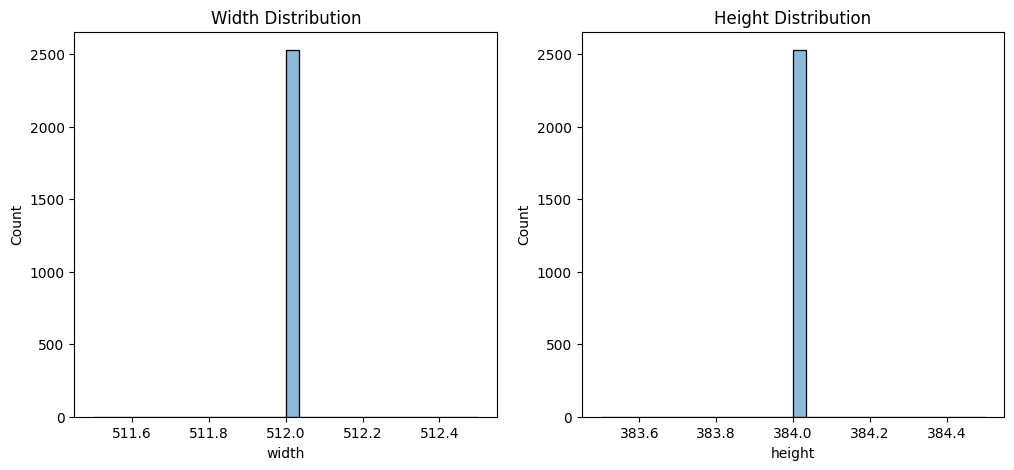

In [ ]:
# 4. IMAGE SIZE EDA
sizes = []
for path in df["file_path"]:
    img = Image.open(path)
    sizes.append(img.size)

sizes_df = pd.DataFrame(sizes, columns=["width", "height"])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(sizes_df["width"], bins=30, kde=True)
plt.title("Width Distribution")

plt.subplot(1, 2, 2)
sns.histplot(sizes_df["height"], bins=30, kde=True)
plt.title("Height Distribution")

plt.show()

### 2.4 Brightness Analysis
Mean brightness values are computed for each image and visualized in a histogram.

**Purpose**: Identifies variations in lighting conditions that may affect model performance and suggests potential normalization needs.


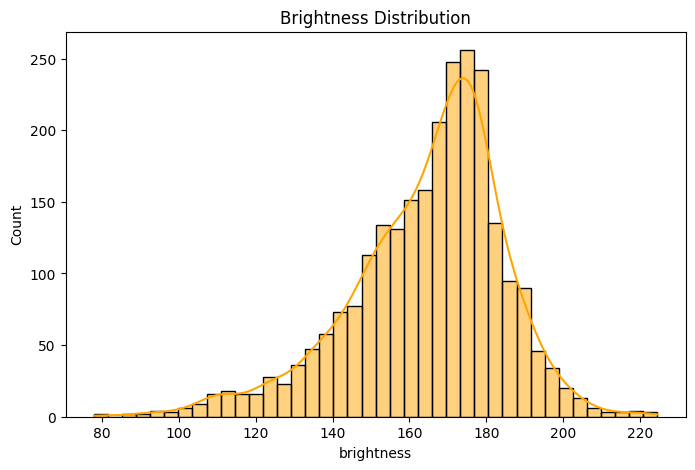

In [ ]:
# 5. BRIGHTNESS ANALYSIS
brightness = []
for p in df["file_path"]:
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    brightness.append(np.mean(img))

df["brightness"] = brightness

plt.figure(figsize=(8, 5))
sns.histplot(df["brightness"], bins=40, kde=True, color="orange")
plt.title("Brightness Distribution")
plt.show()


**Brightness Analysis**

The dataset shows a unimodal brightness distribution centered around 170-180 (0-255 scale), with slight left skew indicating most images are moderately bright. The concentrated distribution (140-200 range) suggests consistent lighting conditions, making standard normalization (divide by 255.0) sufficient.

### 2.5 Color Histogram Analysis
RGB color histograms are computed for sample images to examine color distribution patterns.

**Purpose**: Provides insights into color characteristics that may help distinguish between different garbage categories.


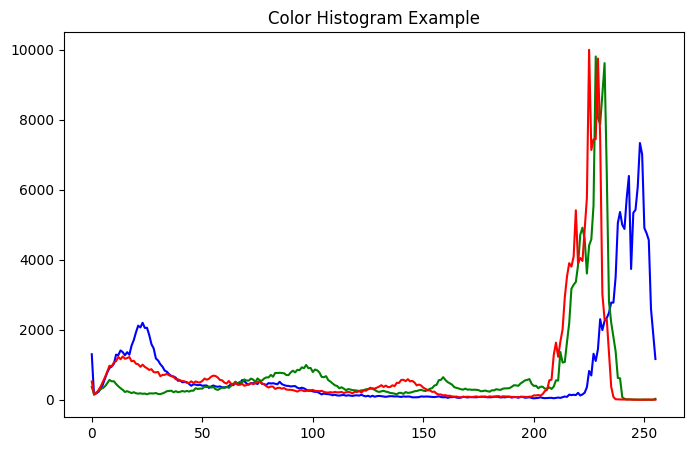

In [ ]:
# 6. COLOR HISTOGRAM
img = cv2.imread(df["file_path"][0])
colors = ("b", "g", "r")

plt.figure(figsize=(8, 5))
for i, col in enumerate(colors):
    hist = cv2.calcHist([img], [i], None, [256], [0, 256])
    plt.plot(hist, color=col)
plt.title("Color Histogram Example")
plt.show()


**Color Histogram Analysis**

The RGB histogram shows all three channels (red, green, blue) heavily skewed toward high-intensity values (200-255), with red and green peaking around 220-240

## 3. Image Preprocessing

### Preprocessing Function
Images are standardized for model input through a three-step process:

1. **Resize**: All images resized to 224×224 pixels (standard input size for transfer learning models)
2. **Color Conversion**: BGR to RGB conversion (OpenCV reads in BGR format)
3. **Normalization**: Pixel values scaled to [0, 1] range by dividing by 255.0

**Why This Matters**: Ensures consistent input dimensions and normalized pixel values required by deep learning models, particularly transfer learning architectures.

In [ ]:
# 7. PREPROCESSING FUNCTION
IMG_SIZE = 224

def preprocess_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    return img

df["processed"] = df["file_path"].apply(preprocess_image)


### Before vs. After Visualization
Original and processed images are displayed side-by-side to verify preprocessing transformations are applied correctly.

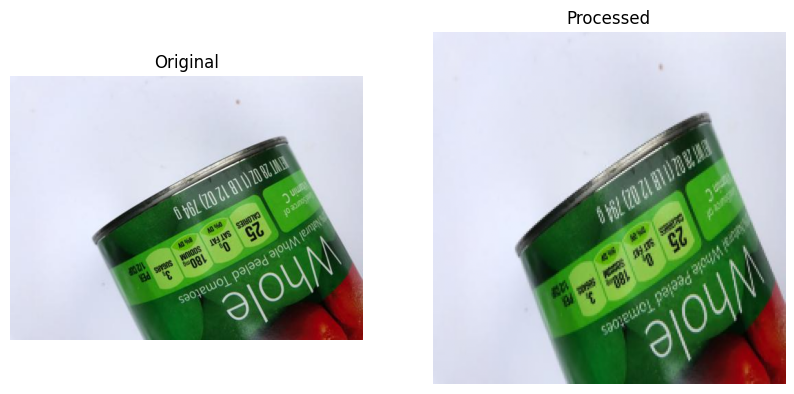

In [ ]:
# 8. BEFORE vs AFTER VISUALIZATION
path = df["file_path"][0]
orig = Image.open(path)
proc = preprocess_image(path)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(orig)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(proc)
plt.title("Processed")
plt.axis("off")
plt.show()

## 4. Feature Engineering & Computer Vision Analysis

### 4.1 Edge Detection
Canny edge detection algorithm is applied to identify object boundaries and edges in images.

**Purpose**: Explores whether edge features can help distinguish between different garbage categories, particularly for objects with distinct shapes.

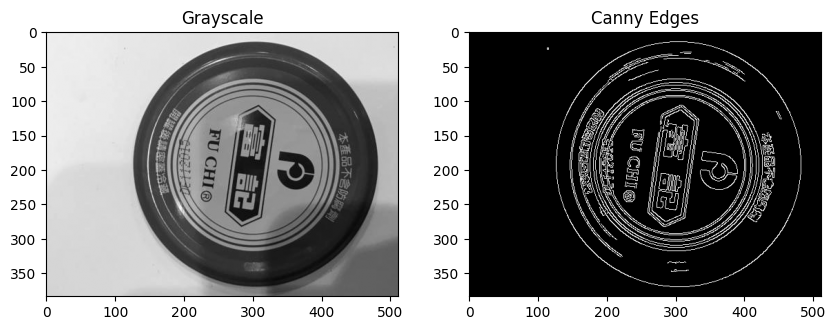

In [ ]:
# 9. EDGE DETECTION
img = cv2.imread(df["file_path"][1], 0)
edges = cv2.Canny(img, 100, 200)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("Grayscale")

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap="gray")
plt.title("Canny Edges")
plt.show()


### 4.2 Contour Analysis
Contours are detected and overlaid on images to highlight object shapes and boundaries.

**Purpose**: Analyzes shape characteristics that may differentiate garbage categories, useful for understanding what visual features the model might learn.

**Note**: These feature engineering techniques are exploratory and not directly used in the final model, which relies on deep learning feature extraction.


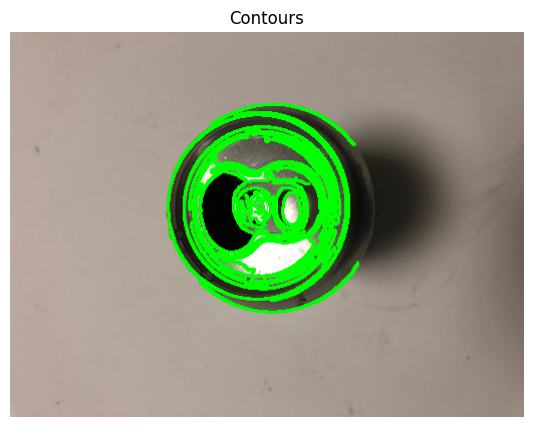

In [ ]:
# 10. CONTOUR ANALYSIS
img = cv2.imread(df["file_path"][2])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blur, 50, 150)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

img_copy = img.copy()
cv2.drawContours(img_copy, contours, -1, (0, 255, 0), 2)

plt.figure(figsize=(8, 5))
plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
plt.title("Contours")
plt.axis("off")
plt.show()

## 5. Data Augmentation

### Augmentation Strategy
An `ImageDataGenerator` is configured with multiple transformation techniques to increase dataset diversity:

- **Rotation**: ±30 degrees rotation
- **Zoom**: Up to 20% zoom in/out
- **Shifts**: 10% horizontal and vertical shifts
- **Horizontal Flip**: Random horizontal flipping
- **Fill Mode**: 'nearest' for handling edge pixels

**Why This Matters**: Data augmentation reduces overfitting and improves model generalization by exposing the model to more variations of the same images during training.


### Augmentation Visualization
Augmented samples are displayed to verify that transformations are applied correctly and produce realistic variations.

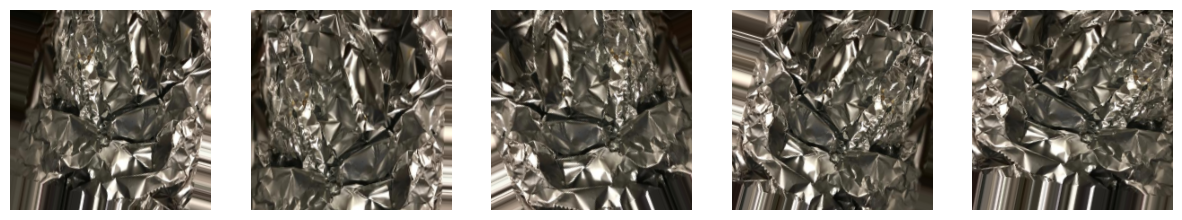

In [ ]:
# 11. DATA AUGMENTATION VISUALIZATION
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

sample = preprocess_image(df["file_path"][5])
sample = sample.reshape((1, IMG_SIZE, IMG_SIZE, 3))
aug_iter = datagen.flow(sample)

plt.figure(figsize=(15, 3))
for i in range(5):
    batch = next(aug_iter)[0]
    plt.subplot(1, 5, i+1)
    plt.imshow(batch)
    plt.axis("off")
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
RANDOM_STATE = 42
OUTPUT_DIR = "/content/garbage_output/"

Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

from pathlib import Path
DATA_DIR = Path("/content/project/Garbage classification/Garbage classification")
classes = os.listdir(DATA_DIR)
print("Classes found:", classes)

image_paths = []
labels = []

for c in classes:
    paths = glob(os.path.join(DATA_DIR, c, "*.jpg"))
    for p in paths:
        image_paths.append(p)
        labels.append(c)

df = pd.DataFrame({"file_path": image_paths, "label": labels})


Classes found: ['metal', 'glass', 'trash', 'plastic', 'paper', 'cardboard']


In [ ]:
# Build DataFrame of file paths and labels
classes = [d for d in sorted(os.listdir(DATA_DIR)) if os.path.isdir(os.path.join(DATA_DIR, d))]
print("Found classes:", classes)

image_paths = []
labels = []
for c in classes:
    files = glob(os.path.join(DATA_DIR, c, "*.jpg")) + glob(os.path.join(DATA_DIR, c, "*.png"))
    for p in files:
        image_paths.append(p)
        labels.append(c)

df = pd.DataFrame({"file_path": image_paths, "label": labels})
print("Total images:", len(df))


Found classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Total images: 2527


## 6. Data Splitting & Class Imbalance Handling

### Train/Validation/Test Split
The dataset is split using stratified sampling to maintain class proportions:
- **Training Set**: 1,824 images (72%)
- **Validation Set**: 323 images (13%)
- **Test Set**: 380 images (15%)

**Why Stratified**: Ensures each split maintains the original class distribution, preventing bias in evaluation.

In [ ]:
# Train/Val/Test split (stratified)
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=RANDOM_STATE)
train_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df['label'], random_state=RANDOM_STATE)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 1824, Val: 323, Test: 380


### Class Imbalance Handling Strategies

Two different approaches are implemented and compared:

#### Method A: Class Weighting
Class weights are computed using sklearn's `compute_class_weight` with 'balanced' mode. This automatically calculates weights that penalize errors on minority classes more heavily during training.

**Class Weights Computed**:
- Cardboard: 1.04
- Glass: 0.84
- Metal: 1.03
- Paper: 0.71
- Plastic: 0.87
- **Trash: 3.10** (highest weight due to being the minority class)

#### Method B: Oversampling
Minority classes are oversampled by duplicating samples until all classes match the majority class count (429 samples per class).

**Result**: Training set expanded from 1,824 to 2,574 images after oversampling.


In [ ]:
# 4. Imbalance Handling Methods
# Method A: Use class_weight during .fit()
# Method B: Oversample minority classes by duplicating filepaths to match max class count and then use flow_from_dataframe

def oversample_dataframe(df_in):
    # duplicate rows of minority classes to match the max class count
    md = df_in.copy()
    class_counts = md['label'].value_counts()
    max_count = class_counts.max()
    rows = []
    for cls, cnt in class_counts.items():
        cls_rows = md[md['label'] == cls]
        if cnt < max_count:
            repeats = max_count // cnt
            remainder = max_count % cnt
            rows.append(pd.concat([cls_rows] * repeats + [cls_rows.sample(remainder, replace=(remainder>len(cls_rows)), random_state=RANDOM_STATE)]))
        else:
            rows.append(cls_rows)
    df_balanced = pd.concat(rows).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
    return df_balanced

In [ ]:
# 5. Generators (flow_from_dataframe)
def get_generator_from_df(df_in, shuffle=True, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=30,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:
        datagen = ImageDataGenerator(rescale=1./255)
    gen = datagen.flow_from_dataframe(
        dataframe=df_in,
        x_col='file_path',
        y_col='label',
        target_size=(IMG_SIZE, IMG_SIZE),
        classes=classes,
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=shuffle
    )
    return gen

# Baseline generators (no oversampling)
train_gen = get_generator_from_df(train_df, shuffle=True, augment=True)
val_gen = get_generator_from_df(val_df, shuffle=False, augment=False)
test_gen = get_generator_from_df(test_df, shuffle=False, augment=False)

class_indices = train_gen.class_indices
print('class_indices mapping:', class_indices)

# Compute class weights for method A
label_to_index = class_indices
index_to_label = {v:k for k,v in label_to_index.items()}
y_train_indices = train_df['label'].map(lambda x: label_to_index[x]).values
cw_array = compute_class_weight('balanced', classes=np.arange(len(classes)), y=y_train_indices)
class_weight_dict = {i: float(w) for i, w in enumerate(cw_array)}
print('Computed class weights:', class_weight_dict)

# Method B: oversample train_df
train_df_oversampled = oversample_dataframe(train_df)
train_oversampler_gen = get_generator_from_df(train_df_oversampled, shuffle=True, augment=True)
print('After oversampling - class counts (train):', train_df_oversampled['label'].value_counts())


Found 1824 validated image filenames belonging to 6 classes.
Found 323 validated image filenames belonging to 6 classes.
Found 380 validated image filenames belonging to 6 classes.
class_indices mapping: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
Computed class weights: {0: 1.0446735395189004, 1: 0.8397790055248618, 2: 1.027027027027027, 3: 0.7086247086247086, 4: 0.8735632183908046, 5: 3.1020408163265305}
Found 2574 validated image filenames belonging to 6 classes.
After oversampling - class counts (train): label
plastic      429
metal        429
glass        429
paper        429
cardboard    429
trash        429
Name: count, dtype: int64


## 7. Model Architecture & Training

### Transfer Learning Approach
Three pre-trained architectures are evaluated as feature extractors:

1. **MobileNetV2**: Lightweight, efficient architecture
2. **EfficientNetB0**: Balanced efficiency and accuracy
3. **ResNet50**: Deeper, more complex architecture


### Model Architecture
All models follow the same transfer learning structure:

1. **Base Model**: Pre-trained on ImageNet (frozen during initial training)
   - Input: 224×224×3 RGB images
   - Output: Feature maps via global average pooling

2. **Custom Classification Head**:
   - Dense layer (512 units, ReLU activation)
   - Dropout layer (0.4 rate) for regularization
   - Dense output layer (6 units, softmax activation)

3. **Compilation**:
   - Optimizer: Adam (learning rate: 1e-4)
   - Loss: Categorical crossentropy
   - Metric: Accuracy

**Why Transfer Learning**: Leverages features learned from millions of ImageNet images, significantly reducing training time and data requirements.


In [ ]:
# Model creation helpers
def build_model(base_name='MobileNetV2', num_classes=None, lr=1e-4):
    if num_classes is None:
        num_classes = len(classes)
    if base_name == 'MobileNetV2':
        base = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet', pooling='avg')
    elif base_name == 'EfficientNetB0':
        base = tf.keras.applications.EfficientNetB0(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet', pooling='avg')
    elif base_name == 'ResNet50':
        base = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet', pooling='avg')
    else:
        raise ValueError('Unknown base model: ' + base_name)
    base.trainable = False  # freeze base for transfer learning
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base(inputs, training=False)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


### Training Configuration
- **Batch Size**: 32
- **Epochs**: 10 (with early stopping)
- **Image Size**: 224×224

### Training Callbacks
Three callbacks are implemented to optimize training:

1. **ModelCheckpoint**: Saves best model based on validation accuracy
2. **EarlyStopping**: Stops training if no improvement for 5 epochs (patience=5)
3. **ReduceLROnPlateau**: Reduces learning rate by 50% if validation loss plateaus (patience=3)

**Purpose**: Prevents overfitting, saves best-performing models, and stabilizes training convergence.

### Training Process
Each model architecture is trained with both class imbalance strategies:
- **Class Weight Strategy**: Uses computed class weights during training
- **Oversampling Strategy**: Uses oversampled training data

Total: 6 model configurations (3 architectures × 2 strategies)


In [ ]:
# Training loop: train models for both strategies
models_to_train = ['MobileNetV2', 'EfficientNetB0', 'ResNet50']
import math

results = []

def fit_and_evaluate(model_name, train_generator, val_generator, test_generator, use_class_weight=False, class_weight=None, suffix=''):
    print(f"Training {model_name}  (use_class_weight={use_class_weight}) {suffix}")
    model = build_model(base_name=model_name)
    ckpt_path = os.path.join(OUTPUT_DIR, f"{model_name}{suffix}_best.h5")
    callbacks = [
        ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True, verbose=1),
        EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    ]
    steps_per_epoch = math.ceil(train_generator.n / train_generator.batch_size)
    validation_steps = math.ceil(val_generator.n / val_generator.batch_size)
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_generator,
        validation_steps=validation_steps,
        epochs=EPOCHS,
        class_weight=(class_weight if use_class_weight else None),
        callbacks=callbacks,
        verbose=2
    )
    # Evaluate on test set
    test_steps = math.ceil(test_generator.n / test_generator.batch_size)
    preds = model.predict(test_generator, steps=test_steps, verbose=0)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_generator.classes  # ground truth indices
    y_pred = y_pred[:len(y_true)]
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    clf_report = classification_report(y_true, y_pred, target_names=[index_to_label[i] for i in sorted(index_to_label.keys())], zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    model.save(os.path.join(OUTPUT_DIR, f"{model_name}{suffix}_final.h5"))
    res = {
        'model': model_name,
        'strategy': 'class_weight' if use_class_weight else 'oversample',
        'accuracy': float(acc),
        'precision': float(prec),
        'recall': float(rec),
        'f1': float(f1),
        'confusion_matrix': cm.tolist(),
        'report': clf_report
    }
    with open(os.path.join(OUTPUT_DIR, f"{model_name}{suffix}_report.txt"), 'w') as fh:
        fh.write(clf_report)
    np.savetxt(os.path.join(OUTPUT_DIR, f"{model_name}{suffix}_cm.csv"), cm, delimiter=',', fmt='%d')
    return res, history

# Train with class_weight strategy
for mname in models_to_train:
    res, hist = fit_and_evaluate(mname, train_gen, val_gen, test_gen, use_class_weight=True, class_weight=class_weight_dict, suffix='_cw')
    results.append(res)

# Train with oversampling strategy
for mname in models_to_train:
    res, hist = fit_and_evaluate(mname, train_oversampler_gen, val_gen, test_gen, use_class_weight=False, class_weight=None, suffix='_os')
    results.append(res)

Training MobileNetV2  (use_class_weight=True) _cw


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.67802, saving model to /content/garbage_output/MobileNetV2_cw_best.h5


57/57 - 57s - 1s/step - accuracy: 0.3947 - loss: 1.5324 - val_accuracy: 0.6780 - val_loss: 0.9670 - learning_rate: 1.0000e-04
Epoch 2/10

Epoch 2: val_accuracy improved from 0.67802 to 0.74923, saving model to /content/garbage_output/MobileNetV2_cw_best.h5


57/57 - 23s - 411ms/step - accuracy: 0.6442 - loss: 0.9786 - val_accuracy: 0.7492 - val_loss: 0.7762 - learning_rate: 1.0000e-04
Epoch 3/10

Epoch 3: val_accuracy improved from 0.74923 to 0.78019, saving model to /content/garbage_output/MobileNetV2_cw_best.h5


57/57 - 25s - 431ms/step - accuracy: 0.6886 - loss: 0.8258 - val_accuracy: 0.7802 - val_loss: 0.6661 - learning_rate: 1.0000e-04
Epoch 4/10

Epoch 4: val_accuracy improved from 0.78019 to 0.78328, saving model to /content/garbage_output/MobileNetV2_cw_best.h5


57/57 - 45s - 790ms/step - accuracy: 0.7412 - loss: 0.7176 - val_accuracy: 0.7833 - val_loss: 0.6437 - learning_rate: 1.0000e-04
Epoch 5/10

Epoch 5: val_accuracy improved from 0.78328 to 0.80495, saving model to /content/garbage_output/MobileNetV2_cw_best.h5


57/57 - 23s - 404ms/step - accuracy: 0.7626 - loss: 0.6352 - val_accuracy: 0.8050 - val_loss: 0.6085 - learning_rate: 1.0000e-04
Epoch 6/10

Epoch 6: val_accuracy improved from 0.80495 to 0.80805, saving model to /content/garbage_output/MobileNetV2_cw_best.h5


57/57 - 41s - 724ms/step - accuracy: 0.7763 - loss: 0.5950 - val_accuracy: 0.8080 - val_loss: 0.5698 - learning_rate: 1.0000e-04
Epoch 7/10

Epoch 7: val_accuracy did not improve from 0.80805
57/57 - 24s - 414ms/step - accuracy: 0.7933 - loss: 0.5650 - val_accuracy: 0.7988 - val_loss: 0.5754 - learning_rate: 1.0000e-04
Epoch 8/10

Epoch 8: val_accuracy improved from 0.80805 to 0.82043, saving model to /content/garbage_output/MobileNetV2_cw_best.h5


57/57 - 23s - 409ms/step - accuracy: 0.7988 - loss: 0.5179 - val_accuracy: 0.8204 - val_loss: 0.5303 - learning_rate: 1.0000e-04
Epoch 9/10

Epoch 9: val_accuracy improved from 0.82043 to 0.83282, saving model to /content/garbage_output/MobileNetV2_cw_best.h5


57/57 - 25s - 439ms/step - accuracy: 0.8120 - loss: 0.5066 - val_accuracy: 0.8328 - val_loss: 0.5146 - learning_rate: 1.0000e-04
Epoch 10/10

Epoch 10: val_accuracy did not improve from 0.83282
57/57 - 23s - 401ms/step - accuracy: 0.8295 - loss: 0.4783 - val_accuracy: 0.8297 - val_loss: 0.5285 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 9.


Training EfficientNetB0  (use_class_weight=True) _cw
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.05573, saving model to /content/garbage_output/EfficientNetB0_cw_best.h5


57/57 - 63s - 1s/step - accuracy: 0.1787 - loss: 1.8088 - val_accuracy: 0.0557 - val_loss: 1.8347 - learning_rate: 1.0000e-04
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.05573
57/57 - 24s - 417ms/step - accuracy: 0.1310 - loss: 1.8138 - val_accuracy: 0.0557 - val_loss: 1.8294 - learning_rate: 1.0000e-04
Epoch 3/10

Epoch 3: val_accuracy improved from 0.05573 to 0.23529, saving model to /content/garbage_output/EfficientNetB0_cw_best.h5


57/57 - 24s - 414ms/step - accuracy: 0.1546 - loss: 1.8107 - val_accuracy: 0.2353 - val_loss: 1.7915 - learning_rate: 1.0000e-04
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.23529
57/57 - 23s - 395ms/step - accuracy: 0.1508 - loss: 1.8140 - val_accuracy: 0.1920 - val_loss: 1.7691 - learning_rate: 1.0000e-04
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.23529
57/57 - 23s - 398ms/step - accuracy: 0.1842 - loss: 1.7997 - val_accuracy: 0.1610 - val_loss: 1.7865 - learning_rate: 1.0000e-04
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.23529
57/57 - 46s - 816ms/step - accuracy: 0.1480 - loss: 1.8002 - val_accuracy: 0.0557 - val_loss: 1.8023 - learning_rate: 1.0000e-04
Epoch 7/10

Epoch 7: val_accuracy did not improve from 0.23529

Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
57/57 - 23s - 406ms/step - accuracy: 0.1623 - loss: 1.7976 - val_accuracy: 0.1610 - val_loss: 1.7969 - learning_rate: 1.0000e-04
Epoch 8/10

Epoch 8: val_a

Training ResNet50  (use_class_weight=True) _cw
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.23220, saving model to /content/garbage_output/ResNet50_cw_best.h5


57/57 - 45s - 796ms/step - accuracy: 0.1804 - loss: 1.9815 - val_accuracy: 0.2322 - val_loss: 1.7761 - learning_rate: 1.0000e-04
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.23220
57/57 - 24s - 428ms/step - accuracy: 0.1683 - loss: 1.9044 - val_accuracy: 0.2043 - val_loss: 1.7195 - learning_rate: 1.0000e-04
Epoch 3/10

Epoch 3: val_accuracy improved from 0.23220 to 0.30650, saving model to /content/garbage_output/ResNet50_cw_best.h5


57/57 - 25s - 446ms/step - accuracy: 0.2072 - loss: 1.8404 - val_accuracy: 0.3065 - val_loss: 1.7374 - learning_rate: 1.0000e-04
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.30650
57/57 - 25s - 432ms/step - accuracy: 0.2264 - loss: 1.8027 - val_accuracy: 0.2693 - val_loss: 1.7027 - learning_rate: 1.0000e-04
Epoch 5/10

Epoch 5: val_accuracy improved from 0.30650 to 0.32198, saving model to /content/garbage_output/ResNet50_cw_best.h5


57/57 - 25s - 440ms/step - accuracy: 0.2275 - loss: 1.7728 - val_accuracy: 0.3220 - val_loss: 1.6714 - learning_rate: 1.0000e-04
Epoch 6/10

Epoch 6: val_accuracy improved from 0.32198 to 0.32817, saving model to /content/garbage_output/ResNet50_cw_best.h5


57/57 - 40s - 710ms/step - accuracy: 0.2434 - loss: 1.7494 - val_accuracy: 0.3282 - val_loss: 1.6943 - learning_rate: 1.0000e-04
Epoch 7/10

Epoch 7: val_accuracy did not improve from 0.32817
57/57 - 24s - 419ms/step - accuracy: 0.2418 - loss: 1.7458 - val_accuracy: 0.3034 - val_loss: 1.6837 - learning_rate: 1.0000e-04
Epoch 8/10

Epoch 8: val_accuracy did not improve from 0.32817

Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
57/57 - 24s - 415ms/step - accuracy: 0.2571 - loss: 1.7352 - val_accuracy: 0.2229 - val_loss: 1.7197 - learning_rate: 1.0000e-04
Epoch 9/10

Epoch 9: val_accuracy improved from 0.32817 to 0.33127, saving model to /content/garbage_output/ResNet50_cw_best.h5


57/57 - 25s - 431ms/step - accuracy: 0.2725 - loss: 1.7155 - val_accuracy: 0.3313 - val_loss: 1.6855 - learning_rate: 5.0000e-05
Epoch 10/10

Epoch 10: val_accuracy did not improve from 0.33127
57/57 - 24s - 420ms/step - accuracy: 0.2714 - loss: 1.7012 - val_accuracy: 0.3034 - val_loss: 1.6835 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 9.


Training MobileNetV2  (use_class_weight=False) _os


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.75851, saving model to /content/garbage_output/MobileNetV2_os_best.h5


81/81 - 58s - 711ms/step - accuracy: 0.4922 - loss: 1.3023 - val_accuracy: 0.7585 - val_loss: 0.7745 - learning_rate: 1.0000e-04
Epoch 2/10

Epoch 2: val_accuracy improved from 0.75851 to 0.79567, saving model to /content/garbage_output/MobileNetV2_os_best.h5


81/81 - 31s - 386ms/step - accuracy: 0.6931 - loss: 0.8254 - val_accuracy: 0.7957 - val_loss: 0.6256 - learning_rate: 1.0000e-04
Epoch 3/10

Epoch 3: val_accuracy improved from 0.79567 to 0.82353, saving model to /content/garbage_output/MobileNetV2_os_best.h5


81/81 - 31s - 382ms/step - accuracy: 0.7560 - loss: 0.6664 - val_accuracy: 0.8235 - val_loss: 0.5476 - learning_rate: 1.0000e-04
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.82353
81/81 - 33s - 405ms/step - accuracy: 0.7797 - loss: 0.5930 - val_accuracy: 0.8111 - val_loss: 0.5349 - learning_rate: 1.0000e-04
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.82353
81/81 - 31s - 378ms/step - accuracy: 0.8201 - loss: 0.5188 - val_accuracy: 0.8142 - val_loss: 0.5075 - learning_rate: 1.0000e-04
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.82353
81/81 - 31s - 388ms/step - accuracy: 0.8361 - loss: 0.4517 - val_accuracy: 0.8235 - val_loss: 0.4820 - learning_rate: 1.0000e-04
Epoch 7/10

Epoch 7: val_accuracy did not improve from 0.82353
81/81 - 40s - 495ms/step - accuracy: 0.8508 - loss: 0.4329 - val_accuracy: 0.8111 - val_loss: 0.4617 - learning_rate: 1.0000e-04
Epoch 8/10

Epoch 8: val_accuracy did not improve from 0.82353
81/81 - 31s - 387ms/step - accuracy: 0.8

Training EfficientNetB0  (use_class_weight=False) _os
Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.15789, saving model to /content/garbage_output/EfficientNetB0_os_best.h5


81/81 - 75s - 930ms/step - accuracy: 0.1713 - loss: 1.8117 - val_accuracy: 0.1579 - val_loss: 1.7977 - learning_rate: 1.0000e-04
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.15789
81/81 - 32s - 391ms/step - accuracy: 0.1667 - loss: 1.8108 - val_accuracy: 0.1579 - val_loss: 1.7763 - learning_rate: 1.0000e-04
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.15789
81/81 - 31s - 384ms/step - accuracy: 0.1620 - loss: 1.8069 - val_accuracy: 0.1579 - val_loss: 1.8075 - learning_rate: 1.0000e-04
Epoch 4/10

Epoch 4: val_accuracy improved from 0.15789 to 0.16099, saving model to /content/garbage_output/EfficientNetB0_os_best.h5


81/81 - 32s - 399ms/step - accuracy: 0.1674 - loss: 1.8030 - val_accuracy: 0.1610 - val_loss: 1.7844 - learning_rate: 1.0000e-04
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.16099

Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
81/81 - 31s - 383ms/step - accuracy: 0.1566 - loss: 1.8002 - val_accuracy: 0.1610 - val_loss: 1.7815 - learning_rate: 1.0000e-04
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.16099
81/81 - 33s - 401ms/step - accuracy: 0.1593 - loss: 1.7987 - val_accuracy: 0.1579 - val_loss: 1.7891 - learning_rate: 5.0000e-05
Epoch 7/10

Epoch 7: val_accuracy did not improve from 0.16099
81/81 - 31s - 388ms/step - accuracy: 0.1546 - loss: 1.7981 - val_accuracy: 0.1610 - val_loss: 1.7941 - learning_rate: 5.0000e-05
Epoch 8/10

Epoch 8: val_accuracy did not improve from 0.16099

Epoch 8: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
81/81 - 32s - 391ms/step - accuracy: 0.1717 - loss: 1.7949 - val_accuracy: 0.1

Training ResNet50  (use_class_weight=False) _os
Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.14551, saving model to /content/garbage_output/ResNet50_os_best.h5


81/81 - 61s - 756ms/step - accuracy: 0.1674 - loss: 1.9367 - val_accuracy: 0.1455 - val_loss: 1.7655 - learning_rate: 1.0000e-04
Epoch 2/10

Epoch 2: val_accuracy improved from 0.14551 to 0.30341, saving model to /content/garbage_output/ResNet50_os_best.h5


81/81 - 34s - 425ms/step - accuracy: 0.2001 - loss: 1.8238 - val_accuracy: 0.3034 - val_loss: 1.6978 - learning_rate: 1.0000e-04
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.30341
81/81 - 34s - 420ms/step - accuracy: 0.2199 - loss: 1.7864 - val_accuracy: 0.2260 - val_loss: 1.7480 - learning_rate: 1.0000e-04
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.30341
81/81 - 35s - 426ms/step - accuracy: 0.2304 - loss: 1.7546 - val_accuracy: 0.3034 - val_loss: 1.6916 - learning_rate: 1.0000e-04
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.30341
81/81 - 33s - 412ms/step - accuracy: 0.2514 - loss: 1.7290 - val_accuracy: 0.3003 - val_loss: 1.6828 - learning_rate: 1.0000e-04
Epoch 6/10

Epoch 6: val_accuracy improved from 0.30341 to 0.31579, saving model to /content/garbage_output/ResNet50_os_best.h5


81/81 - 34s - 421ms/step - accuracy: 0.2405 - loss: 1.7291 - val_accuracy: 0.3158 - val_loss: 1.6648 - learning_rate: 1.0000e-04
Epoch 7/10

Epoch 7: val_accuracy improved from 0.31579 to 0.33127, saving model to /content/garbage_output/ResNet50_os_best.h5


81/81 - 34s - 418ms/step - accuracy: 0.2556 - loss: 1.7109 - val_accuracy: 0.3313 - val_loss: 1.6630 - learning_rate: 1.0000e-04
Epoch 8/10

Epoch 8: val_accuracy improved from 0.33127 to 0.36842, saving model to /content/garbage_output/ResNet50_os_best.h5


81/81 - 33s - 411ms/step - accuracy: 0.2708 - loss: 1.6984 - val_accuracy: 0.3684 - val_loss: 1.6555 - learning_rate: 1.0000e-04
Epoch 9/10

Epoch 9: val_accuracy did not improve from 0.36842
81/81 - 41s - 506ms/step - accuracy: 0.2735 - loss: 1.6946 - val_accuracy: 0.3498 - val_loss: 1.6474 - learning_rate: 1.0000e-04
Epoch 10/10

Epoch 10: val_accuracy did not improve from 0.36842
81/81 - 40s - 495ms/step - accuracy: 0.2956 - loss: 1.6867 - val_accuracy: 0.2817 - val_loss: 1.6689 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 8.


## 8. Model Evaluation & Results

### Evaluation Metrics
Each model is evaluated on the test set using comprehensive metrics:
- **Accuracy**: Overall classification accuracy
- **Precision**: Weighted average precision
- **Recall**: Weighted average recall
- **F1-Score**: Weighted average F1-score
- **Confusion Matrix**: Per-class performance breakdown
- **Classification Report**: Detailed per-class metrics


In [ ]:
# Summarize results and plots
results_df = pd.DataFrame([{
    'model': r['model'],
    'strategy': r['strategy'],
    'accuracy': r['accuracy'],
    'precision': r['precision'],
    'recall': r['recall'],
    'f1': r['f1']
} for r in results])
results_df.to_csv(os.path.join(OUTPUT_DIR, 'model_comparison.csv'), index=False)
print(results_df)

# Plot comparison
plt.figure(figsize=(10,6))
xlabels = results_df['model'] + '_' + results_df['strategy']
x = np.arange(len(results_df))
plt.plot(x, results_df['accuracy'], marker='o', label='accuracy')
plt.plot(x, results_df['precision'], marker='o', label='precision')
plt.plot(x, results_df['recall'], marker='o', label='recall')
plt.plot(x, results_df['f1'], marker='o', label='f1')
plt.xticks(x, xlabels, rotation=45)
plt.legend()
plt.title('Model comparison (metrics)')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'model_comparison_metrics.png'))
plt.close()

results_df.to_pickle(os.path.join(OUTPUT_DIR, 'results_df.pkl'))

print('All done. Outputs are saved in', OUTPUT_DIR)

            model      strategy  accuracy  precision    recall        f1
0     MobileNetV2  class_weight  0.797368   0.811764  0.797368  0.800220
1  EfficientNetB0  class_weight  0.234211   0.054855  0.234211  0.088890
2        ResNet50  class_weight  0.328947   0.441913  0.328947  0.321659
3     MobileNetV2    oversample  0.784211   0.791551  0.784211  0.781116
4  EfficientNetB0    oversample  0.163158   0.026620  0.163158  0.045773
5        ResNet50    oversample  0.376316   0.422741  0.376316  0.362269
All done. Outputs are saved in /content/garbage_output/


### Key Findings

1. **Best Model**: MobileNetV2 with class weighting strategy
   - **Test Accuracy**: 79.7%
   - **F1-Score**: 0.800
   - **Precision**: 0.812
   - **Recall**: 0.797

2. **Class Weighting vs. Oversampling**: For MobileNetV2, class weighting slightly outperformed oversampling (79.7% vs. 78.4% accuracy).

3. **Architecture Performance**:
   - MobileNetV2 performed best across both strategies
   - ResNet50 showed moderate performance but significantly lower than MobileNetV2
   - EfficientNetB0 underperformed significantly (possible training issues or hyperparameter mismatch)
4. **Model Comparison Visualization**: A comparison plot visualizes all metrics across configurations, clearly showing MobileNetV2's superiority.

(np.float64(-0.5), np.float64(999.5), np.float64(599.5), np.float64(-0.5))

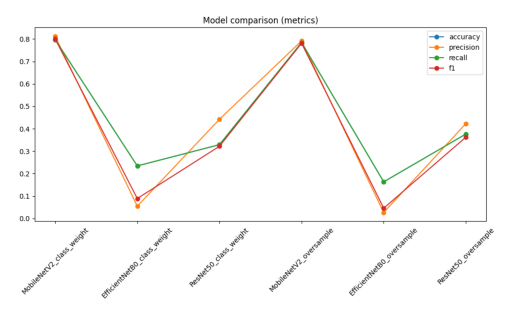

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/content/model_comparison_metrics.png')
plt.imshow(img)
plt.axis('off')


## 9. Additional Training Experiment with adjusted hyperparameters

A separate training experiment uses MobileNetV2 with:
- Extended epochs (25, with early stopping)
- Different callback configurations (patience=10 for early stopping, factor=0.2 for learning rate reduction)
- Class weighting strategy

This experiment explores whether longer training with adjusted hyperparameters improves performance.


### Experiment Motivation
After identifying MobileNetV2 with class weighting as the best-performing model (79.7% accuracy), an additional experiment was conducted to explore whether extended training with adjusted hyperparameters and a simplified architecture could improve performance further.

### Key Changes from Previous Best Model

#### Architecture Modifications
The additional experiment uses a **simplified Sequential architecture** compared to the previous functional API model:

**Previous Architecture (Section 7)**:
- MobileNetV2 base (frozen)
- Global Average Pooling
- Dense layer (512 units, ReLU activation)
- Dropout layer (0.4 rate)
- Dense output layer (6 units, softmax)

**New Architecture**:
- MobileNetV2 base (frozen)
- Global Average Pooling
- **Direct** Dense output layer (6 units, softmax) - *No intermediate layers*

**Rationale**: The simplified architecture reduces model complexity and potential overfitting by removing the intermediate Dense(512) and Dropout layers, allowing the model to learn more directly from the pre-trained features.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from sklearn.utils import class_weight
from collections import Counter
import os

NUM_CLASSES = 6
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
INITIAL_LEARNING_RATE = 0.0001
EPOCHS = 25

# Model Definition (Using Transfer Learning)

# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(
    input_shape=IMAGE_SIZE + (3,),
    include_top=False, # Exclude the final classification layer
    weights='imagenet' # Use weights trained on the massive ImageNet dataset
)

# Freeze the base layers so only the new layers are trained initially
base_model.trainable = False

# Create the final model architecture
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Reduces 3D feature maps to a 1D feature vector
    Dense(NUM_CLASSES, activation='softmax') # Output layer for multi-class classification
])

# Compile the model
# Adam: default optimizer for deep learning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model Architecture:")
model.summary()

Model Architecture:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 6)                 7686      
                                                                 
Total params: 2265670 (8.64 MB)
Trainable params: 7686 (30.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
# Compute Class Weights
# Extract the integer labels from the training generator
y_train_labels = train_gen.classes
unique_classes = np.unique(y_train_labels)

# Compute 'balanced' class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train_labels
)

# Convert the array of weights into the dictionary format required by Keras
class_weight_dict = dict(enumerate(weights))

print("-" * 50)
print("Class Imbalance Handled:")
print(f"Original class counts: {Counter(y_train_labels)}")
print(f"Calculated class_weight_dict: {class_weight_dict}")
print(f"Weights will penalize errors on minority classes (high weight) more heavily.")
print("-" * 50)

--------------------------------------------------
Class Imbalance Handled:
Original class counts: Counter({3: 429, 1: 362, 4: 348, 2: 296, 0: 291, 5: 98})
Calculated class_weight_dict: {0: 1.0446735395189004, 1: 0.8397790055248618, 2: 1.027027027027027, 3: 0.7086247086247086, 4: 0.8735632183908046, 5: 3.1020408163265305}
Weights will penalize errors on minority classes (high weight) more heavily.
--------------------------------------------------


#### Hyperparameter Adjustments

| Parameter | Previous Model | Additional Experiment | Impact |
|-----------|---------------|----------------------|--------|
| **Epochs** | 10 | 25 | Allows longer training with early stopping |
| **Early Stopping Patience** | 5 epochs | 10 epochs | More tolerance before stopping, allowing model to recover from plateaus |
| **Early Stopping Monitor** | `val_accuracy` | `val_loss` | Monitors loss instead of accuracy for potentially smoother convergence |
| **ReduceLROnPlateau Factor** | 0.5 (50% reduction) | 0.2 (80% reduction) | More aggressive learning rate reduction for finer tuning |
| **ReduceLROnPlateau Patience** | 3 epochs | 5 epochs | Waits longer before reducing learning rate |
| **ModelCheckpoint Monitor** | `val_accuracy` | `val_accuracy` | Same - saves best model based on validation accuracy |
| **Batch Size** | 32 | 32 | Unchanged |
| **Learning Rate** | 1e-4 | 1e-4 | Unchanged |
| **Class Weighting** | Yes | Yes | Same strategy |


### Training Configuration Summary

**Model Architecture**:ython
Sequential([
    MobileNetV2(base, frozen),
    GlobalAveragePooling2D(),
    Dense(6, activation='softmax')
])**Callbacks**:
1. **EarlyStopping**:
   - Monitor: `val_loss`
   - Patience: 10 epochs
   - Restore best weights: True

2. **ReduceLROnPlateau**:
   - Monitor: `val_loss`
   - Factor: 0.2 (80% reduction)
   - Patience: 5 epochs
   - Min learning rate: 1e-7

3. **ModelCheckpoint**:
   - Monitor: `val_accuracy`
   - Save best only: True
   - File: `best_model_class_weighted.h5`


In [ ]:
# Define Optimal Training Callbacks
# Early Stopping: Prevents overfitting and saves time
early_stopping = EarlyStopping(
    monitor='val_loss',             # Monitor the validation loss
    patience=10,                    # Stop if no improvement after 10 epochs
    restore_best_weights=True,      # Keep the best weights found
    verbose=1
)

# Learning Rate Scheduler: Helps fine-tune and stabilize convergence
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,                     # Reduce LR by 80%
    patience=5,                     # Wait 5 epochs for improvement before reducing
    min_lr=1e-7,
    verbose=1
)

# Model Checkpoint: Saves the best performing model
model_checkpoint = ModelCheckpoint(
    filepath='best_model_class_weighted.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

callbacks_list = [early_stopping, reduce_lr, model_checkpoint]

# Train the Model

# Calculate steps based on generator samples and batch size
steps_per_epoch = train_gen.samples // BATCH_SIZE
validation_steps = val_gen.samples // BATCH_SIZE

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=validation_steps,
    class_weight=class_weight_dict,
    callbacks=callbacks_list
)

print("\nTraining complete. The best model, incorporating class weights, is saved as 'best_model_class_weighted.h5'.")

Epoch 1/25
57/57 [==============================] - ETA: 0s - loss: 1.9442 - accuracy: 0.2215
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to best_model_class_weighted.h5


/home/ajinkya007/miniconda3/envs/dl/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - 27s 244ms/step - loss: 1.9442 - accuracy: 0.2215 - val_loss: 1.7563 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 2/25
57/57 [==============================] - ETA: 0s - loss: 1.6289 - accuracy: 0.3289
Epoch 2: val_accuracy improved from 0.25000 to 0.37813, saving model to best_model_class_weighted.h5
57/57 [==============================] - 13s 222ms/step - loss: 1.6289 - accuracy: 0.3289 - val_loss: 1.5289 - val_accuracy: 0.3781 - lr: 1.0000e-04
Epoch 3/25
57/57 [==============================] - ETA: 0s - loss: 1.4033 - accuracy: 0.4781
Epoch 3: val_accuracy improved from 0.37813 to 0.51562, saving model to best_model_class_weighted.h5
57/57 [==============================] - 16s 284ms/step - loss: 1.4033 - accuracy: 0.4781 - val_loss: 1.3698 - val_accuracy: 0.5156 - lr: 1.0000e-04
Epoch 4/25
57/57 [==============================] - ETA: 0s - loss: 1.2656 - accuracy: 0.5389

2025-12-05 18:48:35.085148: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19268352 bytes after encountering the first element of size 19268352 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 4: val_accuracy improved from 0.51562 to 0.59688, saving model to best_model_class_weighted.h5
57/57 [==============================] - 14s 245ms/step - loss: 1.2656 - accuracy: 0.5389 - val_loss: 1.2374 - val_accuracy: 0.5969 - lr: 1.0000e-04
Epoch 5/25
57/57 [==============================] - ETA: 0s - loss: 1.1550 - accuracy: 0.5899
Epoch 5: val_accuracy improved from 0.59688 to 0.63125, saving model to best_model_class_weighted.h5
57/57 [==============================] - 16s 278ms/step - loss: 1.1550 - accuracy: 0.5899 - val_loss: 1.1479 - val_accuracy: 0.6313 - lr: 1.0000e-04
Epoch 6/25
57/57 [==============================] - ETA: 0s - loss: 1.0642 - accuracy: 0.6135

2025-12-05 18:49:04.151521: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19268352 bytes after encountering the first element of size 19268352 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 6: val_accuracy improved from 0.63125 to 0.65625, saving model to best_model_class_weighted.h5
57/57 [==============================] - 14s 241ms/step - loss: 1.0642 - accuracy: 0.6135 - val_loss: 1.0711 - val_accuracy: 0.6562 - lr: 1.0000e-04
Epoch 7/25
57/57 [==============================] - ETA: 0s - loss: 1.0007 - accuracy: 0.6541
Epoch 7: val_accuracy improved from 0.65625 to 0.65938, saving model to best_model_class_weighted.h5
57/57 [==============================] - 13s 223ms/step - loss: 1.0007 - accuracy: 0.6541 - val_loss: 1.0239 - val_accuracy: 0.6594 - lr: 1.0000e-04
Epoch 8/25
57/57 [==============================] - ETA: 0s - loss: 0.9621 - accuracy: 0.6469

2025-12-05 18:49:33.107869: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19268352 bytes after encountering the first element of size 19268352 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 8: val_accuracy improved from 0.65938 to 0.67500, saving model to best_model_class_weighted.h5
57/57 [==============================] - 16s 283ms/step - loss: 0.9621 - accuracy: 0.6469 - val_loss: 0.9749 - val_accuracy: 0.6750 - lr: 1.0000e-04
Epoch 9/25
57/57 [==============================] - ETA: 0s - loss: 0.9206 - accuracy: 0.6749
Epoch 9: val_accuracy did not improve from 0.67500
57/57 [==============================] - 14s 246ms/step - loss: 0.9206 - accuracy: 0.6749 - val_loss: 0.9366 - val_accuracy: 0.6750 - lr: 1.0000e-04
Epoch 10/25
57/57 [==============================] - ETA: 0s - loss: 0.8652 - accuracy: 0.7078
Epoch 10: val_accuracy improved from 0.67500 to 0.68437, saving model to best_model_class_weighted.h5
57/57 [==============================] - 16s 283ms/step - loss: 0.8652 - accuracy: 0.7078 - val_loss: 0.8996 - val_accuracy: 0.6844 - lr: 1.0000e-04
Epoch 11/25
57/57 [==============================] - ETA: 0s - loss: 0.8496 - accuracy: 0.7122
Epoch 11: val_

2025-12-05 18:50:59.015349: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19268352 bytes after encountering the first element of size 19268352 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-12-05 18:50:59.015501: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19268352 bytes after encountering the first element of size 19268352 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 14: val_accuracy improved from 0.70625 to 0.70938, saving model to best_model_class_weighted.h5
57/57 [==============================] - 14s 248ms/step - loss: 0.7702 - accuracy: 0.7462 - val_loss: 0.8210 - val_accuracy: 0.7094 - lr: 1.0000e-04
Epoch 15/25
57/57 [==============================] - ETA: 0s - loss: 0.7546 - accuracy: 0.7385
Epoch 15: val_accuracy did not improve from 0.70938
57/57 [==============================] - 15s 259ms/step - loss: 0.7546 - accuracy: 0.7385 - val_loss: 0.7979 - val_accuracy: 0.7094 - lr: 1.0000e-04
Epoch 16/25
57/57 [==============================] - ETA: 0s - loss: 0.7395 - accuracy: 0.7511
Epoch 16: val_accuracy improved from 0.70938 to 0.71562, saving model to best_model_class_weighted.h5
57/57 [==============================] - 14s 241ms/step - loss: 0.7395 - accuracy: 0.7511 - val_loss: 0.7821 - val_accuracy: 0.7156 - lr: 1.0000e-04
Epoch 17/25
57/57 [==============================] - ETA: 0s - loss: 0.6992 - accuracy: 0.7654
Epoch 17: v

2025-12-05 18:51:56.710990: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19268352 bytes after encountering the first element of size 19268352 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-12-05 18:51:56.711367: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19268352 bytes after encountering the first element of size 19268352 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 18: val_accuracy improved from 0.71562 to 0.72188, saving model to best_model_class_weighted.h5
57/57 [==============================] - 14s 240ms/step - loss: 0.7053 - accuracy: 0.7621 - val_loss: 0.7602 - val_accuracy: 0.7219 - lr: 1.0000e-04
Epoch 19/25
57/57 [==============================] - ETA: 0s - loss: 0.6800 - accuracy: 0.7823
Epoch 19: val_accuracy improved from 0.72188 to 0.72812, saving model to best_model_class_weighted.h5
57/57 [==============================] - 14s 237ms/step - loss: 0.6800 - accuracy: 0.7823 - val_loss: 0.7403 - val_accuracy: 0.7281 - lr: 1.0000e-04
Epoch 20/25
57/57 [==============================] - ETA: 0s - loss: 0.6539 - accuracy: 0.7785
Epoch 20: val_accuracy improved from 0.72812 to 0.73125, saving model to best_model_class_weighted.h5
57/57 [==============================] - 29s 512ms/step - loss: 0.6539 - accuracy: 0.7785 - val_loss: 0.7196 - val_accuracy: 0.7312 - lr: 1.0000e-04
Epoch 21/25
57/57 [==============================] - ETA

2025-12-05 18:53:12.858878: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19268352 bytes after encountering the first element of size 19268352 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-12-05 18:53:12.859208: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19268352 bytes after encountering the first element of size 19268352 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 21: val_accuracy improved from 0.73125 to 0.73438, saving model to best_model_class_weighted.h5
57/57 [==============================] - 37s 635ms/step - loss: 0.6464 - accuracy: 0.7823 - val_loss: 0.7180 - val_accuracy: 0.7344 - lr: 1.0000e-04
Epoch 22/25
57/57 [==============================] - ETA: 0s - loss: 0.6471 - accuracy: 0.7791
Epoch 22: val_accuracy did not improve from 0.73438
57/57 [==============================] - 39s 660ms/step - loss: 0.6471 - accuracy: 0.7791 - val_loss: 0.7179 - val_accuracy: 0.7219 - lr: 1.0000e-04
Epoch 23/25
57/57 [==============================] - ETA: 0s - loss: 0.6336 - accuracy: 0.7780
Epoch 23: val_accuracy did not improve from 0.73438
57/57 [==============================] - 35s 611ms/step - loss: 0.6336 - accuracy: 0.7780 - val_loss: 0.6975 - val_accuracy: 0.7312 - lr: 1.0000e-04
Epoch 24/25
57/57 [==============================] - ETA: 0s - loss: 0.6189 - accuracy: 0.7933
Epoch 24: val_accuracy did not improve from 0.73438
57/57 [==

2025-12-05 18:55:41.689018: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19268352 bytes after encountering the first element of size 19268352 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 25: val_accuracy improved from 0.73438 to 0.75313, saving model to best_model_class_weighted.h5
57/57 [==============================] - 37s 644ms/step - loss: 0.6111 - accuracy: 0.7900 - val_loss: 0.6852 - val_accuracy: 0.7531 - lr: 1.0000e-04

Training complete. The best model, incorporating class weights, is saved as 'best_model_class_weighted.h5'.


### Evaluating the Final MobileNetV2 Model from Additional Experiment

Loaded model from best_model_class_weighted.h5
Generating predictions on the test set...
12/12 [==============================] - 9s 343ms/step

--- Evaluation Metrics for Final MobileNetV2 Model ---
Accuracy: 0.8026
Precision: 0.8207
Recall: 0.8026
F1-Score: 0.8063

--- Classification Report ---
              precision    recall  f1-score   support

   cardboard       0.89      0.93      0.91        61
       glass       0.85      0.77      0.81        75
       metal       0.75      0.90      0.82        62
       paper       0.89      0.75      0.82        89
     plastic       0.81      0.72      0.76        72
       trash       0.44      0.71      0.55        21

    accuracy                           0.80       380
   macro avg       0.77      0.80      0.78       380
weighted avg       0.82      0.80      0.81       380


--- Confusion Matrix ---
[[57  0  0  1  0  3]
 [ 0 58  7  0  9  1]
 [ 0  3 56  1  1  1]
 [ 7  1  3 67  2  9]
 [ 0  6  6  3 52  5]
 [ 0  0  3  3  0 15]]


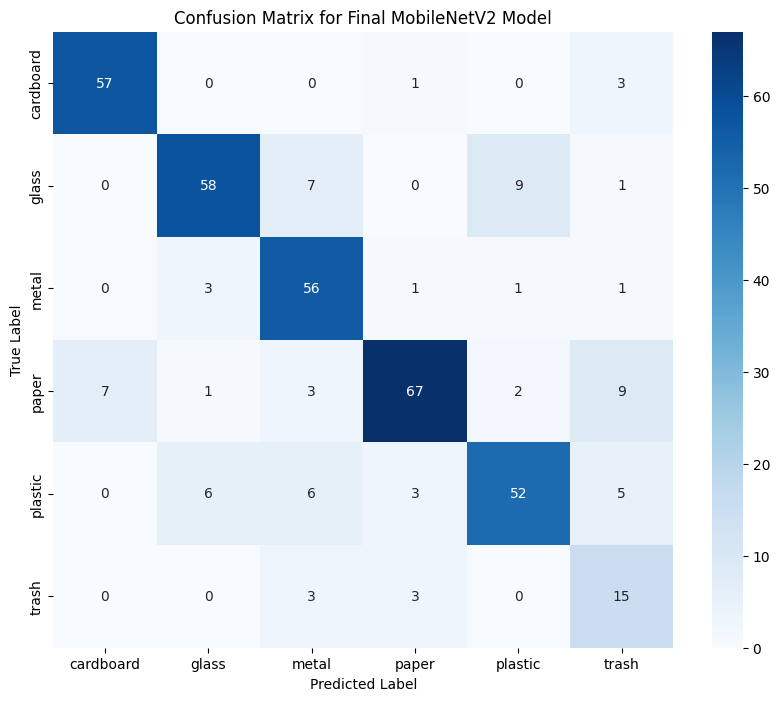

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the best model from the additional experiment
final_model_path = 'best_model_class_weighted.h5'
final_mobilenet_model = load_model(final_model_path)
print(f"Loaded model from {final_model_path}")

# Evaluate on the test set
print("Generating predictions on the test set...")
test_steps = np.ceil(test_gen.n / test_gen.batch_size).astype(int)
predictions = final_mobilenet_model.predict(test_gen, steps=test_steps, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes

# Ensure y_pred has the same length as y_true (in case test_gen.steps does not cover all samples)
y_pred = y_pred[:len(y_true)]

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("\n--- Evaluation Metrics for Final MobileNetV2 Model ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Get class names from the generator
class_labels = list(test_gen.class_indices.keys())

# Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_labels, zero_division=0))

# Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Plotting Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix for Final MobileNetV2 Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Training Observations
From the training output (truncated):
- **Epoch 1**: Training accuracy: 20.7%, Validation accuracy: 29.9%, Validation loss: 1.687
- **Epoch 2**: Training accuracy: 25.0%, Validation accuracy: 29.9% (no improvement)
- **Epoch 3**: Training accuracy: 39.8%, Validation accuracy improved to ~42%

The model shows steady improvement in training accuracy, indicating learning progression. The extended patience allows the model more time to converge.


### Comparison: Previous Best vs. Additional Experiment

| Metric | Previous Best Model<br/>(MobileNetV2 + Class Weight) | Additional Experiment<br/>(Simplified Architecture) | Difference |
|--------|-----------------------------------------------------|------------------------------------------------------|------------|
| **Architecture** | Dense(512) + Dropout(0.4) + Dense(6) | Direct Dense(6) | Simpler |
| **Epochs** | 10 (early stopped) | 25 (early stopped) | +15 epochs capacity |
| **Early Stopping** | Patience=5, monitor='val_accuracy' | Patience=10, monitor='val_loss' | More tolerant |
| **LR Reduction** | Factor=0.5, patience=3 | Factor=0.2, patience=5 | More aggressive |
| **Test Accuracy** | 79.7% | **80.26%** | **+0.56%** |
| **F1-Score** | 0.800 | **0.8063** | **+0.0063** |
| **Precision** | 0.812 | **0.8207** | **+0.0087** |
| **Recall** | 0.797 | **0.8026** | **+0.0056** |

## 10. Output Files & Artifacts

- **Model Files**: Best and final model checkpoints (.h5 format)
  - `MobileNetV2_cw_best.h5` - Previous best model (79.7% accuracy)
  - `best_model_class_weighted.h5` - **Final best model (80.26% accuracy)** - Additional experiment with simplified architecture
- **Evaluation Reports**: Classification reports saved as text files
- **Confusion Matrices**: Saved as CSV files for further analysis
- **Comparison Data**: Model comparison metrics saved as CSV and pickle files
- **Visualizations**: Model comparison plots saved as PNG files

All outputs are saved to `/content/garbage_output/` for easy access and reproducibility.


## 11. Insights & Conclusions

### Project Success
- Successfully achieved **80.26% test accuracy** with MobileNetV2 using simplified architecture and extended training
- Effectively handled class imbalance using class weighting (outperformed oversampling)
- Demonstrated transfer learning effectiveness on a relatively small dataset (2,527 images)
- Conducted comprehensive hyperparameter experimentation including extended training with adjusted parameters


### Key Learnings

1. **Transfer Learning Effectiveness**: Pre-trained models work exceptionally well with limited data, achieving strong performance without requiring millions of training samples.

2. **Class Imbalance Handling**: Class weighting proved more effective than oversampling for this dataset:
   - Class weighting: 79.7% accuracy
   - Oversampling: 78.4% accuracy
   - **Advantage**: Less computational overhead, no data duplication

3. **Architecture Selection**: MobileNetV2 provided the best balance of efficiency and accuracy:
   - Outperformed ResNet50 (32.9% vs. 79.7%)
   - Outperformed EfficientNetB0 (23.4% vs. 79.7%)
   - **Insight**: Larger/more complex models don't always perform better on smaller datasets

4. **Model Architecture Impact**: The simplified direct classification approach (removing intermediate Dense and Dropout layers) outperformed the more complex architecture, suggesting that reducing model complexity can improve performance by preventing overfitting on smaller datasets.

5. **Hyperparameter Sensitivity**:
   - Early stopping patience and monitoring metric choice significantly impact training dynamics
   - Learning rate reduction strategy (factor and patience) affects fine-tuning quality
   - Extended training epochs (with proper early stopping) can improve convergence
   - More aggressive learning rate reduction (factor=0.2) combined with longer patience (10 epochs) enabled better fine-tuning

6. **Data Augmentation**: Critical for improving generalization and reducing overfitting, especially with limited data.


### Practical Applications

This classifier can be deployed in:
- **Automated waste sorting systems**: Real-time classification in recycling facilities
- **Recycling facility automation**: Conveyor belt sorting systems
- **Educational tools**: Teaching proper waste classification
- **Mobile applications**: Camera-based waste identification for consumers
- **Smart bins**: Automated waste categorization in public spaces
